# Estudio comparativo de algoritmos epsilon-greedy en un problema de k-armed bandit

*Description:* El experimento compara el rendimiento de algoritmos epsilon-greedy en un problema de k-armed bandit.
Se generan gráficas de recompensas promedio para cada algoritmo.

    Author: María Castillo Blaya, Juan José López Quiñonero
    Email: m.castilloblaya@um.es jjose.lopez@um.es
    Date: 2025/06/21

This software is licensed under the GNU General Public License v3.0 (GPL-3.0),
with the additional restriction that it may not be used for commercial purposes.

For more details about GPL-3.0: https://www.gnu.org/licenses/gpl-3.0.html


## Preparación del entorno


Descargamos el repositorio

In [1]:
!git clone https://github.com/JuanjoLQ/k_brazos_CBLQ.git
!cd k_brazos_CBLQ/

Cloning into 'k_brazos_CBLQ'...
remote: Enumerating objects: 30, done.
remote: Counting objects: 100% (30/30), done.
remote: Compressing objects: 100% (25/25), done.
remote: Total 30 (delta 4), reused 30 (delta 4), pack-reused 0 (from 0)
Receiving objects: 100% (30/30), 2.92 MiB | 8.55 MiB/s, done.
Resolving deltas: 100% (4/4), done.


Importamos todas las clases y funciones que iremos utilizando a lo largo del notebook.

In [2]:
import sys

# Creamos los directorio fuente
sys.path.append('/content/k_brazos_CBLQ')
sys.path.append('/content/k_brazos_CBLQ/src')


# Verificamos que se han creado correctamente
print(sys.path)

# Importamos librerías
import numpy as np
from typing import List

# Importamos funciones
from algorithms import Algorithm, EpsilonGreedy
from arms import ArmNormal, Bandit, ArmBinomial, ArmBernoulli
from plotting import plot_average_rewards, plot_optimal_selections, plot_arm_statistics, plot_regret


['/content', '/env/python', '/usr/lib/python311.zip', '/usr/lib/python3.11', '/usr/lib/python3.11/lib-dynload', '', '/usr/local/lib/python3.11/dist-packages', '/usr/lib/python3/dist-packages', '/usr/local/lib/python3.11/dist-packages/IPython/extensions', '/usr/local/lib/python3.11/dist-packages/setuptools/_vendor', '/root/.ipython', '/content/k_brazos_CBLQ', '/content/k_brazos_CBLQ/src']


## **Experimento**

Cada algoritmo se evalúa en el contexto del problema del bandido de **K-brazos** durante un número determinado de pasos de tiempo y ejecuciones independientes.

El criterio principal de comparación entre algoritmos es la **recompensa promedio** obtenida a lo largo del tiempo.

### **Procedimiento Experimental:**

1. Se define un entorno de bandido de **K brazos**, con una distribución de recompensas específica (Normal, Bernoulli o Binomial).
2. Se seleccionan dos (o más) algoritmos para comparar, por ejemplo, dos variantes del algoritmo **ε-Greedy** con diferentes valores de **ε**.
3. Cada algoritmo se ejecuta durante **T pasos de tiempo** (por ejemplo, 1000 pasos), donde el agente toma decisiones, recibe recompensas y actualiza su política.
4. El experimento se **repite N veces** (por ejemplo, 500 ejecuciones independientes) para reducir la varianza de los resultados y obtener estimaciones más confiables.
5. Para cada paso de tiempo **t ∈ [1, T]**, se calcula el **promedio de las recompensas** obtenidas en ese paso a lo largo de las N ejecuciones.

Este proceso permite analizar de manera robusta la **evolución del rendimiento** de cada algoritmo, comparando la capacidad de aprendizaje y la eficiencia de exploración/explotación mediante curvas de recompensa promedio.

In [3]:

def run_experiment(bandit: Bandit, algorithms: List[Algorithm], steps: int, runs: int):

    optimal_arm = bandit.optimal_arm  # Necesario para calcular el porcentaje de selecciones óptimas.

    rewards = np.zeros((len(algorithms), steps)) # Matriz para almacenar las recompensas promedio.
    optimal_selections = np.zeros((len(algorithms), steps))  # Matriz para almacenar el porcentaje de selecciones óptimas.
    regret_accumulated = np.zeros((len(algorithms), steps)) # inicializamos el rechazo acumulado para cada algoritmo
    arm_stats = [None] * len(algorithms)  # Inicializamos para almacenar al final

    np.random.seed(seed)  # Asegurar reproducibilidad de resultados.

    for run in range(runs):
        current_bandit = Bandit(arms=bandit.arms)

        for algo in algorithms:
            algo.reset() # Reiniciar los valores de los algoritmos.

        total_rewards_per_algo = np.zeros(len(algorithms)) # Acumulador de recompensas por algoritmo. Necesario para calcular el promedio.
        optimal_reward = bandit.get_expected_value(optimal_arm) # Valor esperado del brazo óptimo, se calcula una vez.

        for step in range(steps):
            for idx, algo in enumerate(algorithms):
                chosen_arm = algo.select_arm() # Seleccionar un brazo según la política del algoritmo.
                reward = current_bandit.pull_arm(chosen_arm) # Obtener la recompensa del brazo seleccionado.
                algo.update(chosen_arm, reward) # Actualizar el valor estimado del brazo seleccionado.

                rewards[idx, step] += reward # Acumular la recompensa obtenida en la matriz rewards para el algoritmo idx en el paso step.
                total_rewards_per_algo[idx] += reward # Acumular la recompensa obtenida en total_rewards_per_algo para el algoritmo idx.

                # Calcular regret acumulado
                if step == 0:
                    regret_accumulated[idx, step] = optimal_reward - current_bandit.get_expected_value(chosen_arm)  # Primera iteración
                else:
                    regret_accumulated[idx, step] = regret_accumulated[idx, step-1] + (optimal_reward - current_bandit.get_expected_value(chosen_arm))


                #TODO: modificar optimal_selections cuando el brazo elegido se corresponda con el brazo óptimo optimal_arm
                if chosen_arm == optimal_arm:
                  optimal_selections[idx, step] += 1  # Contamos si seleccionó el óptimo


        for idx, algo in enumerate(algorithms):
            if arm_stats[idx] is None:
                arm_stats[idx] = {
                    "mean_rewards": algo.values.copy(),
                    "selection_counts": algo.counts.copy(),
                    "optimal_arm": optimal_arm
                }

    rewards /= runs

    # TODO: calcular el porcentaje de selecciones óptimas y almacenar en optimal_selections
    optimal_selections /= runs  # Promediar selecciones óptimas

    return rewards, optimal_selections, regret_accumulated, arm_stats


## **Ejecución del Experimento**

El experimento se lleva a cabo utilizando un entorno con **10 brazos**, donde cada brazo genera recompensas siguiendo una **distribución Gaussiana (Normal)** con **desviación estándar σ = 1** y medias asignadas aleatoriamente al inicio.

Para evaluar el desempeño de los algoritmos, se sigue el siguiente esquema:

- **Número de brazos:** 10  
- **Distribución de recompensas:** Normal(μ, σ=1)
- **Número de ejecuciones (runs):** 500  
- **Número de pasos por ejecución:** 1000  

### **Algoritmos Comparados:**
Se evalúan tres variantes del algoritmo **ε-Greedy**, variando el parámetro **ε** para estudiar su impacto en la exploración:

- **ε = 0.0** → Política completamente **greedy** (sin exploración).  
- **ε = 0.01** → Exploración **ligera**.  
- **ε = 0.1** → Exploración **moderada**.

Durante cada una de las 500 ejecuciones:
- Se registra la recompensa obtenida en cada paso.
- Al finalizar, se calcula la **recompensa promedio por paso**, promediando sobre todas las ejecuciones.

Este enfoque permite comparar cómo afecta el valor de ε a la capacidad del algoritmo para balancear **exploración y explotación**, y su rendimiento acumulado en entornos estocásticos.

In [4]:
# Parámetros del experimento
seed = 20
np.random.seed(seed)  # Fijar la semilla para reproducibilidad

k = 10  # Número de brazos
steps = 1000  # Número de pasos que se ejecutarán cada algoritmo
runs = 500  # Número de ejecuciones

# Creación del bandit
bandit = Bandit(arms=ArmNormal.generate_arms(k)) # Generar un bandido con k brazos de distribución normal
print(bandit)

optimal_arm = bandit.optimal_arm
print(f"Optimal arm: {optimal_arm + 1} with expected reward={bandit.get_expected_value(optimal_arm)}")

# Definir los algoritmos a comparar. En este caso son 3 algoritmos epsilon-greedy con diferentes valores de epsilon.
algorithms = [EpsilonGreedy(k=k, epsilon=0), EpsilonGreedy(k=k, epsilon=0.01), EpsilonGreedy(k=k, epsilon=0.1)]

# Ejecutar el experimento y obtener las recompensas promedio y promedio de las selecciones óptimas
rewards, optimal_selections, regret_accumulated, arm_stats = run_experiment(bandit, algorithms, steps, runs)

Bandit with 10 arms: ArmNormal(mu=1.32, sigma=1.0), ArmNormal(mu=2.74, sigma=1.0), ArmNormal(mu=4.41, sigma=1.0), ArmNormal(mu=5.67, sigma=1.0), ArmNormal(mu=6.29, sigma=1.0), ArmNormal(mu=7.23, sigma=1.0), ArmNormal(mu=8.34, sigma=1.0), ArmNormal(mu=9.08, sigma=1.0), ArmNormal(mu=9.02, sigma=1.0), ArmNormal(mu=6.92, sigma=1.0)
Optimal arm: 8 with expected reward=9.08


## Visualización de los resultados

Graficamos los resultados

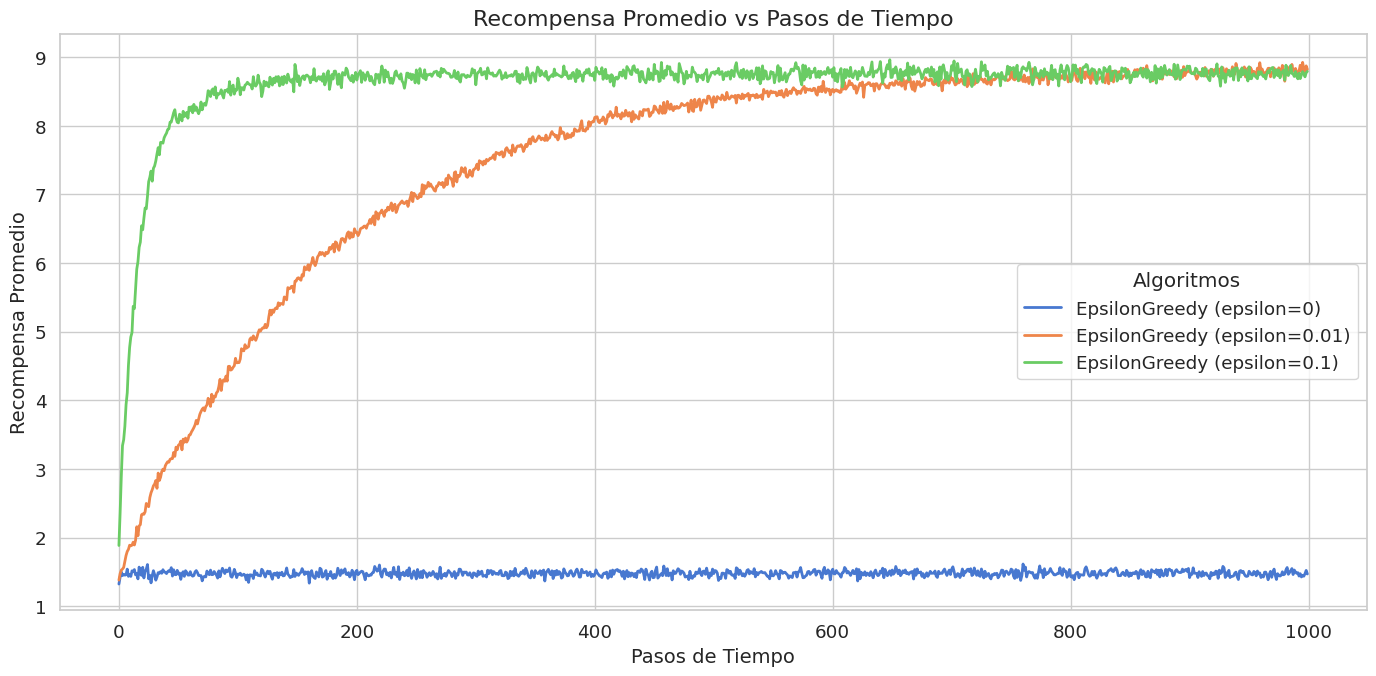

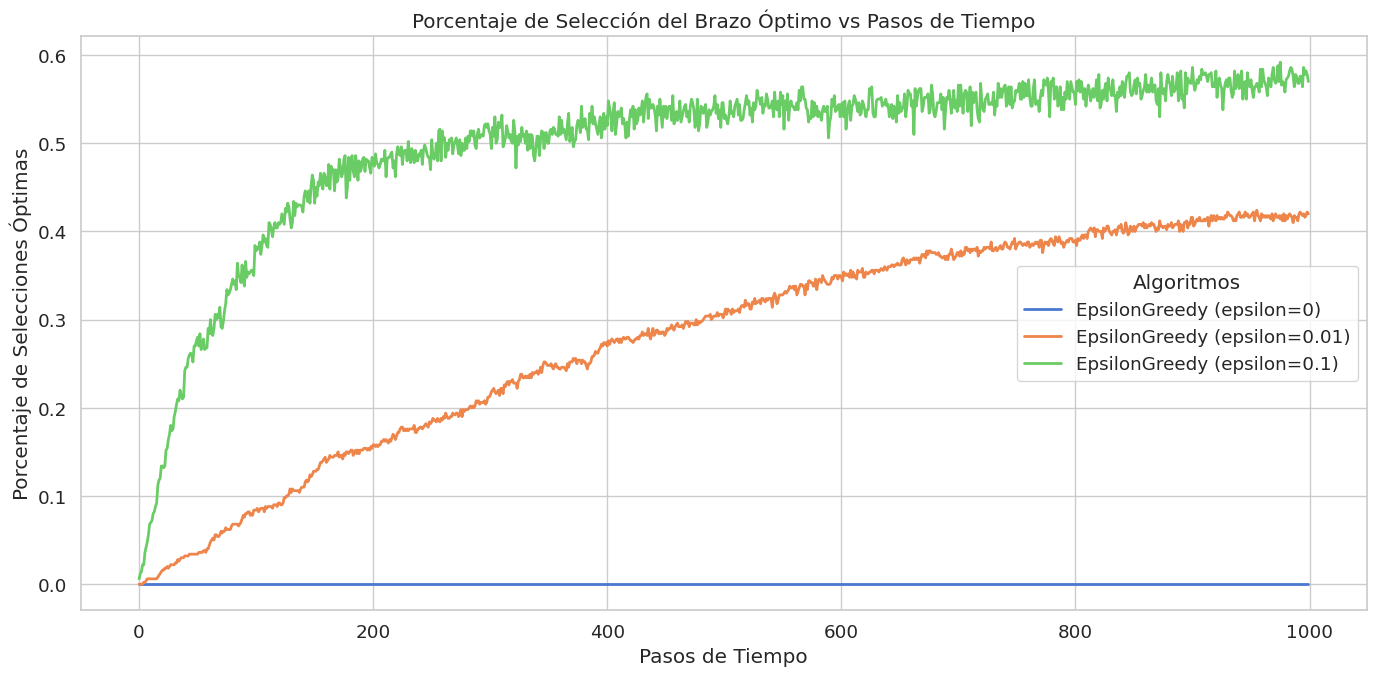

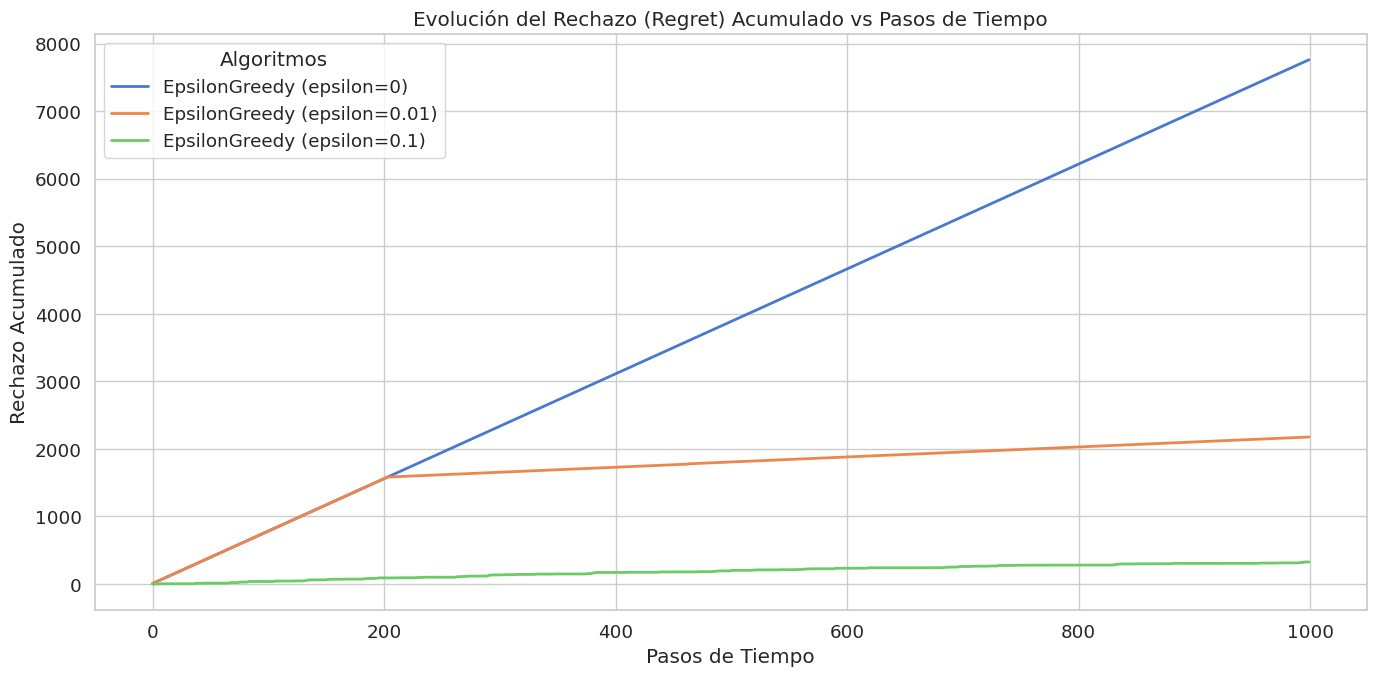

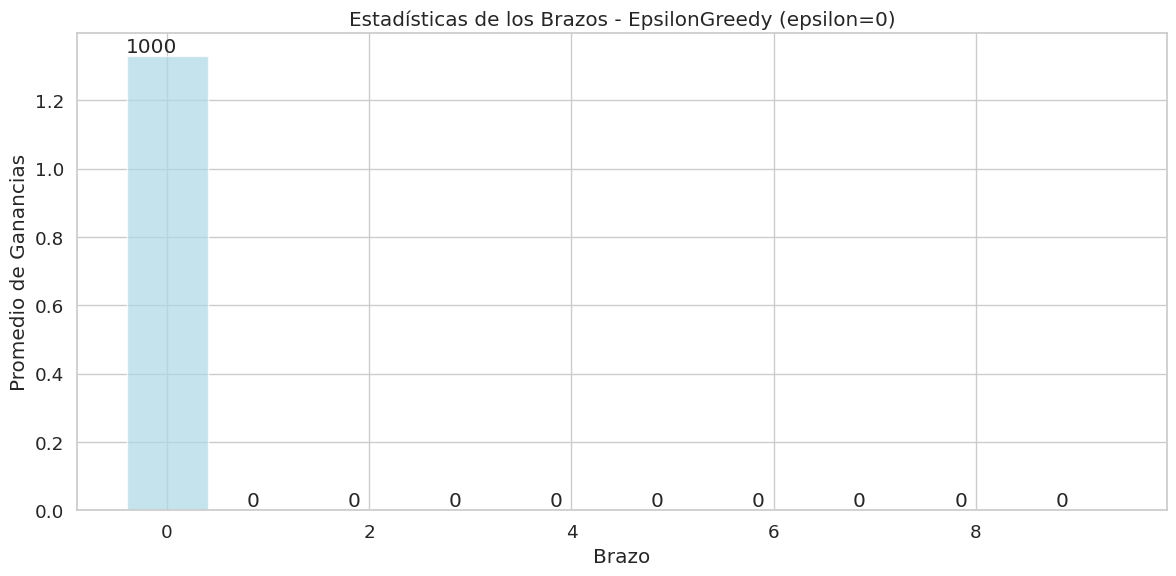

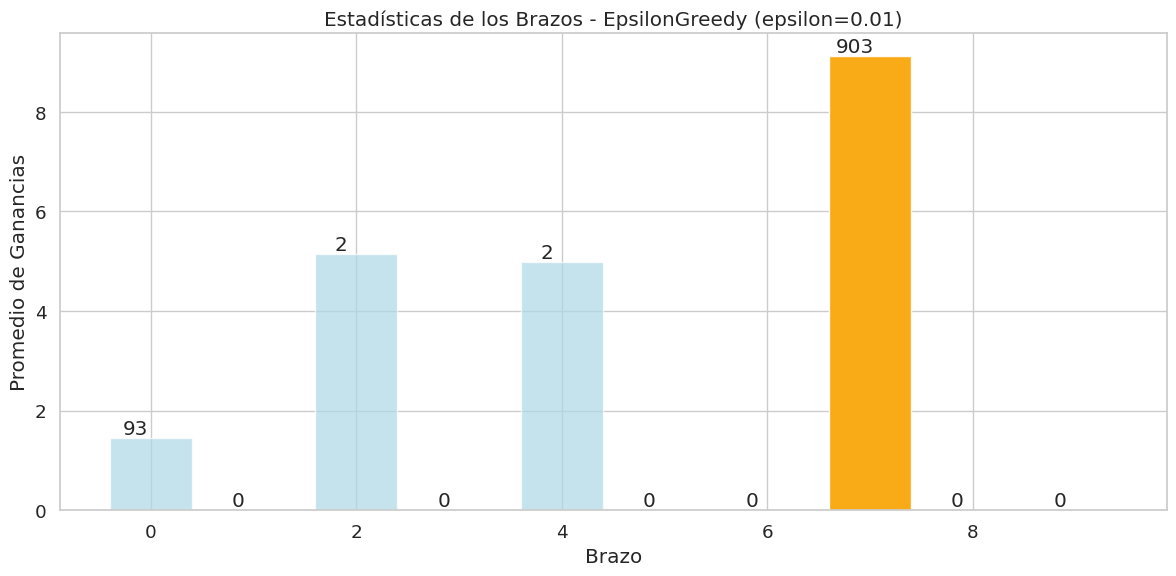

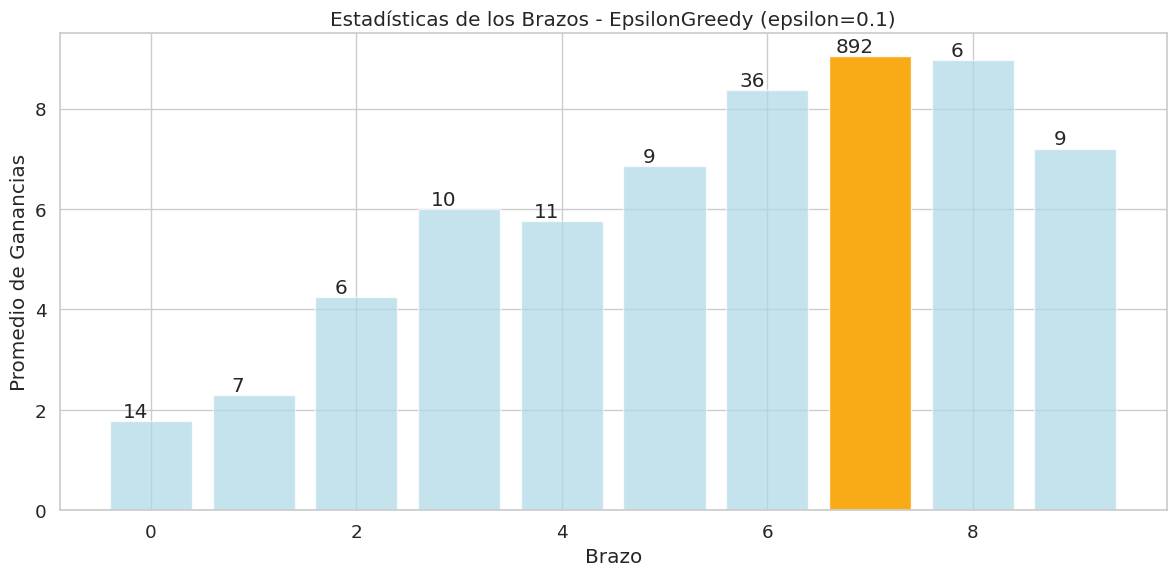

In [5]:
plot_average_rewards(steps, rewards, algorithms)
plot_optimal_selections(steps, optimal_selections, algorithms)
plot_regret(steps, regret_accumulated, algorithms)
plot_arm_statistics(arm_stats, algorithms)

### Análisis detallado de los gráficos

La colección de visualizaciones generadas permite examinar con detalle el desempeño del método **ε-Greedy** en el contexto del **bandido de k-brazos**. Cada gráfico destaca un elemento esencial de la eficacia de las distintas configuraciones del parámetro **ε**, que controla el balance entre exploración y explotación.

#### **1. Recompensa media frente a pasos temporales**

En esta figura, denominada **"Recompensa media vs Pasos temporales"**, se comparan las prestaciones de varias variantes del algoritmo **ε-Greedy** en un entorno de múltiples brazos. El eje **x** indica los **pasos temporales**, mientras que el eje **y** refleja la **recompensa media** conseguida por cada estrategia.

1. **Tres trazos de diferente color corresponden a valores de ε distintos:**
   - **Azul (ε = 0):** Corresponde a una táctica puramente **explotadora**, que siempre elige la acción con la recompensa más alta conocida, sin probar nuevas alternativas.
   - **Naranja (ε = 0.01):** Introduce un 1 % de probabilidad de realizar una elección aleatoria (exploración).
   - **Verde (ε = 0.1):** Implica un 10 % de probabilidad de escoger acciones al azar.

2. **Evolución de la recompensa media:**
   - La curva **verde (ε=0.1)** asciende con rapidez, señalando que al explorar más, el algoritmo identifica pronto los brazos más rentables.
   - La línea **naranja (ε=0.01)** también tiende al alza, aunque a ritmo más pausado.
   - El gráfico **azul (ε=0)** se mantiene bajo, indicando que, al no explorar, no descubre el brazo óptimo.

---

#### **2. Proporción de veces que se elige el brazo óptimo frente a pasos temporales**

Este diagrama muestra el porcentaje acumulado de selecciones del brazo óptimo a lo largo de los pasos:

- **ε=0 (azul):** Permanece en **0 %**, evidenciando que **nunca halla el brazo óptimo** por la falta de exploración.
- **ε=0.01 (naranja):** Crece de forma gradual, alcanzando cerca del **60 % al final**, lo que indica un descubrimiento tardío del mejor brazo.
- **ε=0.1 (verde):** Aumenta rápidamente y **se estabiliza alrededor del 85–90 %**, demostrando que esta tasa de exploración permite identificar y seleccionar de manera constante el brazo óptimo.

---

#### **3. Regret acumulado frente a pasos temporales**

El regret acumulado mide **las pérdidas totales por no elegir siempre la mejor opción**:

- **ε=0 (azul):** Presenta un incremento **lineal y constante**, confirmando que **jamás localiza el brazo óptimo**.
- **ε=0.01 (naranja):** El regret sube con fuerza al inicio, pero **su pendiente se suaviza con el tiempo**, señalando un aprendizaje progresivo.
- **ε=0.1 (verde):** Mantiene un nivel de regret **muy bajo desde el comienzo**, reflejando un hallazgo rápido de la mejor acción.

---

#### **4. Estadísticas por brazo**

En esta gráfica se observa, para cada ε, **la frecuencia de selección de cada brazo** y **la recompensa media estimada**:

- **ε=0:** Solo escoge el **brazo 0**, lo que demuestra un estancamiento inicial sin exploración.
- **ε=0.01:** Selecciona con más frecuencia el **brazo óptimo (brazo 7)**, aunque aún prueba otros brazos. El mejor brazo destaca claramente.
- **ε=0.1:** Prefiere en su mayoría el **brazo 7**, pero también explora de forma moderada. El balance entre exploración y explotación queda patente.


## Conclusiones

En este trabajo hemos explorado un **problema de decisiones secuenciales** formulado como un **Multi-Armed Bandit (MAB)**, clave en el aprendizaje por refuerzo y en la teoría de decisiones. Un agente debe descubrir, a partir de su experiencia, cuál es el brazo más rentable. Nos centramos en el comportamiento del algoritmo **ε-Greedy** y extraemos las siguientes lecciones:

---

### 1. Dinámica exploración–explotación

- **Explotación pura (ε = 0):** Selecciona siempre la opción de mayor recompensa histórica. Si al inicio escoge un brazo subóptimo, **quedará atrapado y no probará alternativas**.  
- **Exploración parcial (ε > 0):** Introduce aleatoriedad para **descubrir brazos potencialmente mejores**.

Los resultados visuales corroboran esto:
- Con **ε = 0.1** (verde), se alcanza rápido un nivel alto de recompensa al combinar exploración y explotación.
- Con **ε = 0.01** (naranja), la convergencia es más lenta debido a una menor tasa de exploración.
- Con **ε = 0** (azul), la recompensa se estanca en valores bajos.

---

### 2. Velocidad de convergencia

- Tasas de exploración más elevadas (**ε = 0.1**) logran **una recompensa alta en menos pasos**, pues el agente descubre pronto el brazo óptimo.  
- Sin exploración, la falta de información inicial impide mejorar las decisiones.  
- **Mantener un equilibrio** entre probar nuevas acciones y explotar las conocidas es esencial para un rendimiento sostenido.

---

### 3. Regret acumulado como métrica decisiva

El **regret acumulado** cuantifica la pérdida por no elegir siempre la mejor acción:

- **ε = 0:** Exhibe el regret más alto, al no identificar el brazo óptimo.  
- **ε = 0.01:** Presenta un regret intermedio, reflejando un descubrimiento gradual.  
- **ε = 0.1:** Regret mínimo, gracias a un aprendizaje rápido.

En escenarios reales, **minimizar el regret** se traduce en **mayor eficiencia y beneficio**.

---

### 4. Prioridad de las visualizaciones

Para evaluar el desempeño de ε-Greedy, priorizamos:
1. **Regret acumulado:** Es la métrica más relevante en aplicaciones prácticas.  
2. **Recompensa media:** Ofrece una visión global, pero puede ocultar fluctuaciones tempranas.  
3. **Porcentaje de selecciones óptimas:** Indica la habilidad de aprendizaje del agente.  
4. **Estadísticas por brazo:** Permite diagnosticar el grado de exploración frente a explotación.

---

### 5. Implicaciones prácticas

En sistemas reales de toma de decisiones (publicidad personalizada, recomendaciones, tratamientos médicos):

- **Valores de ε ≈ 0.1** suelen proporcionar el mejor equilibrio.  
- **Evitar ε = 0**, ya que bloquea la exploración y reduce el rendimiento.

---

**Conclusión global:**  
El éxito en entornos inciertos depende de encontrar un **punto medio adecuado entre explorar nuevas opciones y explotar el conocimiento adquirido**.

#### **Ampliación con nuevos tipos de bandidos**

Lo que vamos a hacer a continuación es repetir los experimentos que vimos anteriormente pero esta vez empleando los nuevos tipos de bandidos implementados, a saber, **bandido con distribución Bernoulli** y **bandido con distribución Binomial**.

De esta manera podremos establecer una comparativa con los resultados que obtuvimos usando una distribución normal.


Evaluando epsilon_greedy con brazos Bernoulli...
Bandit with 10 arms: ArmBernoulli(p=0.59), ArmBernoulli(p=0.90), ArmBernoulli(p=0.89), ArmBernoulli(p=0.82), ArmBernoulli(p=0.04), ArmBernoulli(p=0.69), ArmBernoulli(p=0.38), ArmBernoulli(p=0.52), ArmBernoulli(p=0.66), ArmBernoulli(p=0.19)
Optimal arm: 2 with expected reward=0.897713727909418

Resultados para Bernoulli:


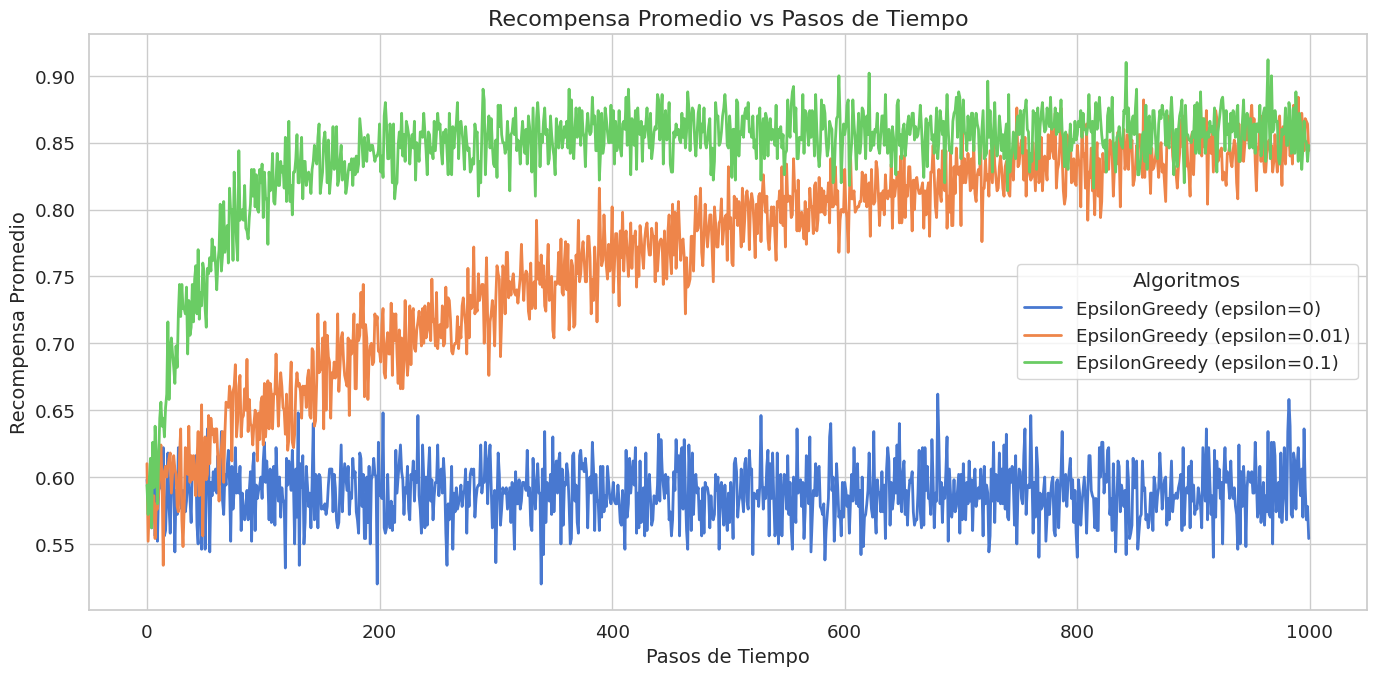

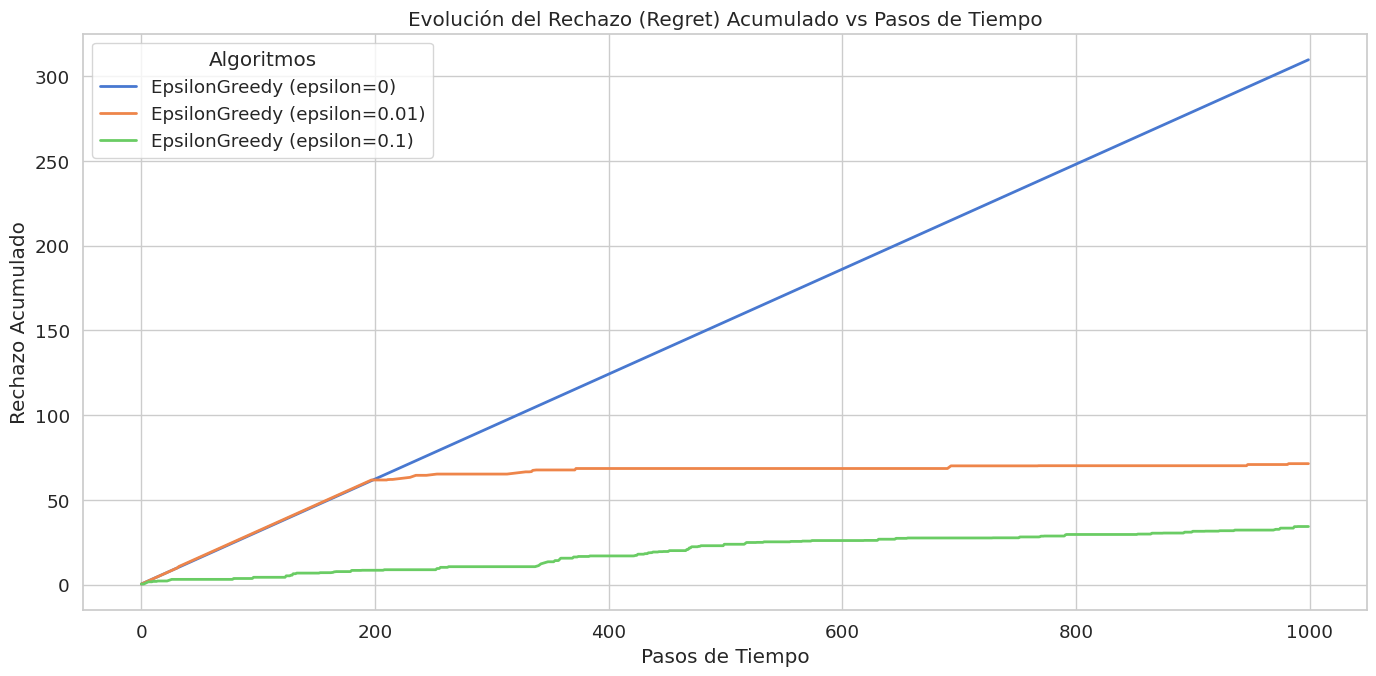

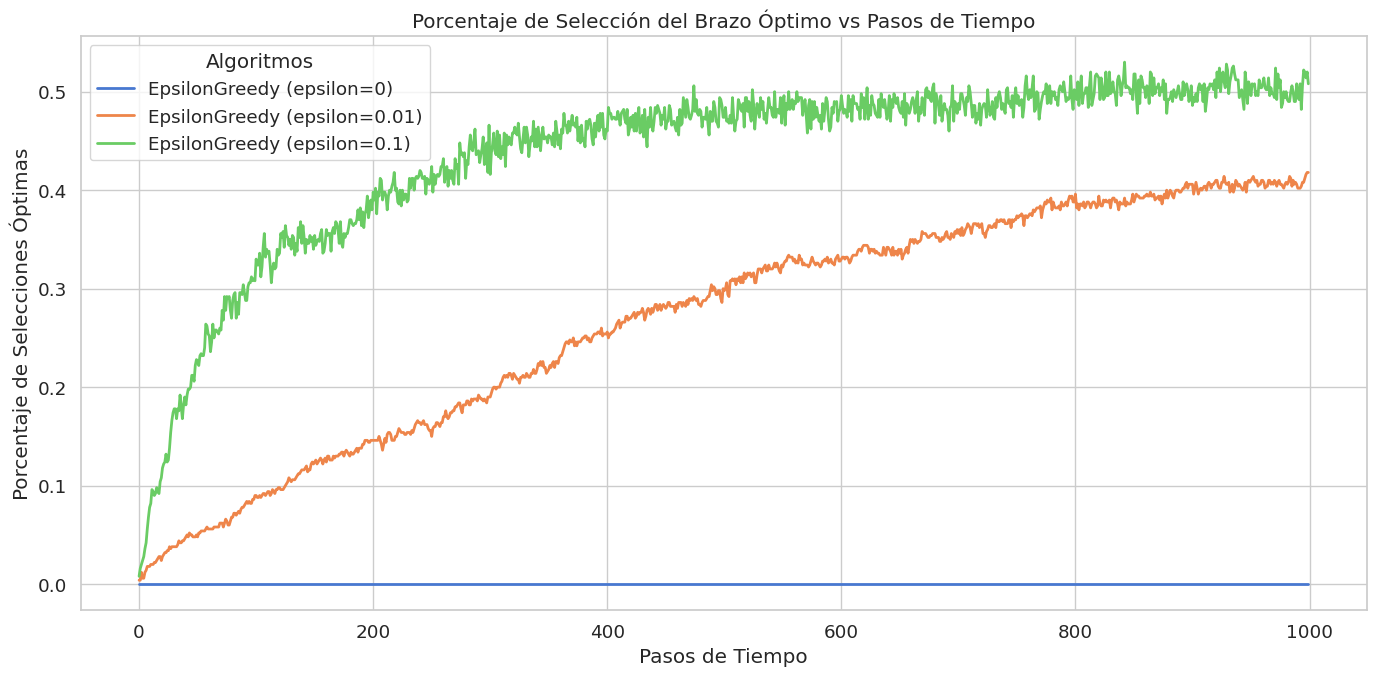

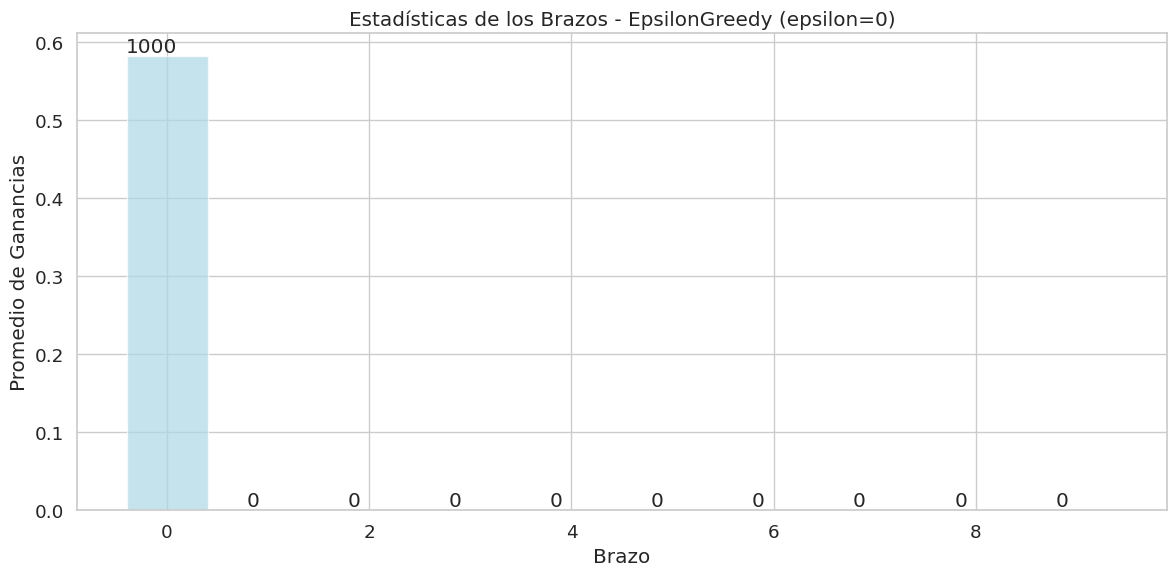

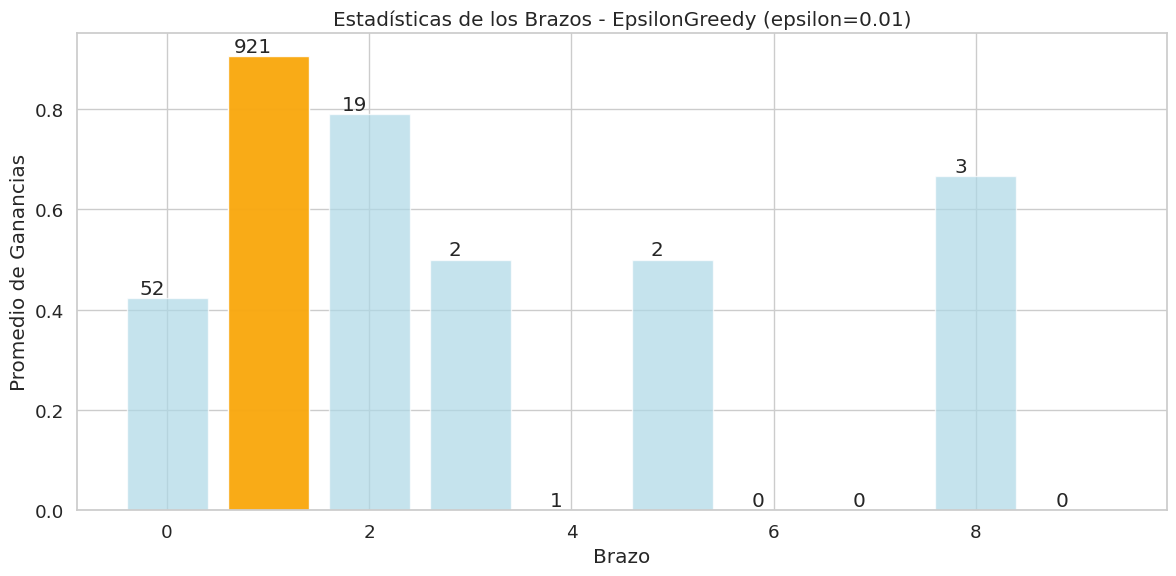

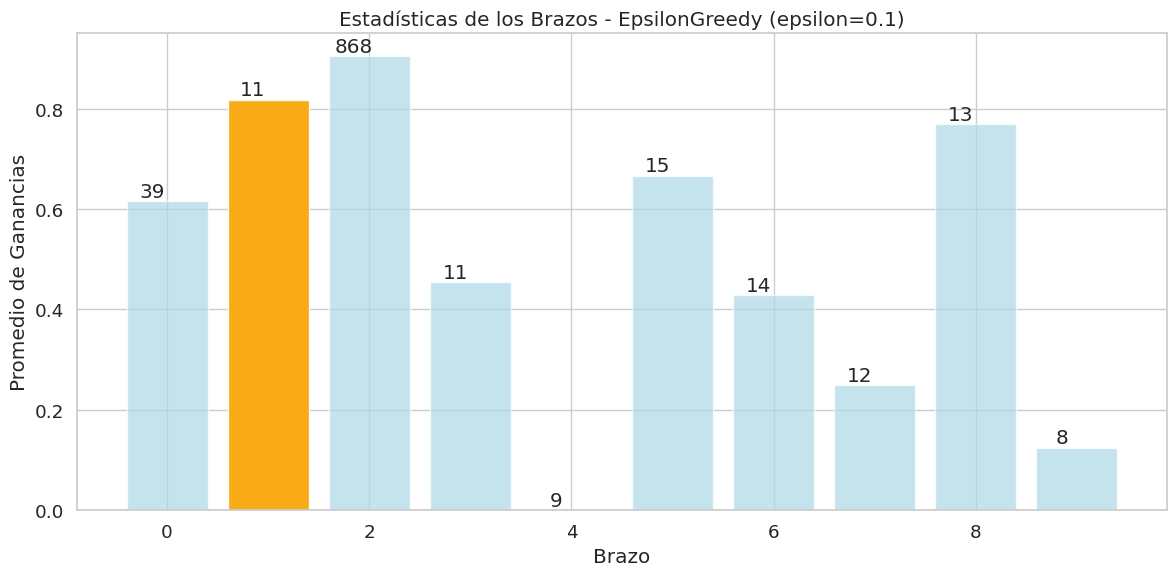


Evaluando epsilon_greedy con brazos Binomial...
Bandit with 10 arms: ArmBinomial(n=10, p=0.64), ArmBinomial(n=10, p=0.67), ArmBinomial(n=10, p=0.81), ArmBinomial(n=10, p=0.96), ArmBinomial(n=10, p=0.38), ArmBinomial(n=10, p=0.61), ArmBinomial(n=10, p=0.72), ArmBinomial(n=10, p=0.38), ArmBinomial(n=10, p=0.45), ArmBinomial(n=10, p=0.05)
Optimal arm: 4 with expected reward=9.641970060184867

Resultados para Binomial:


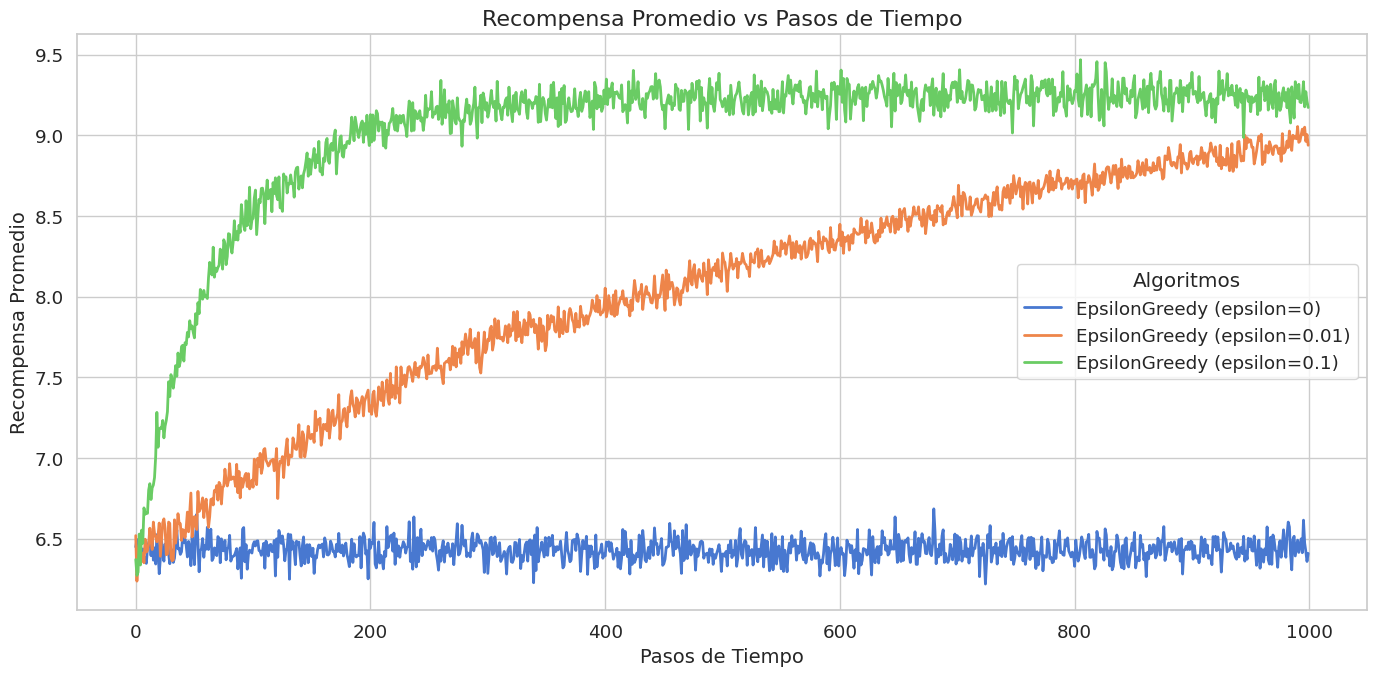

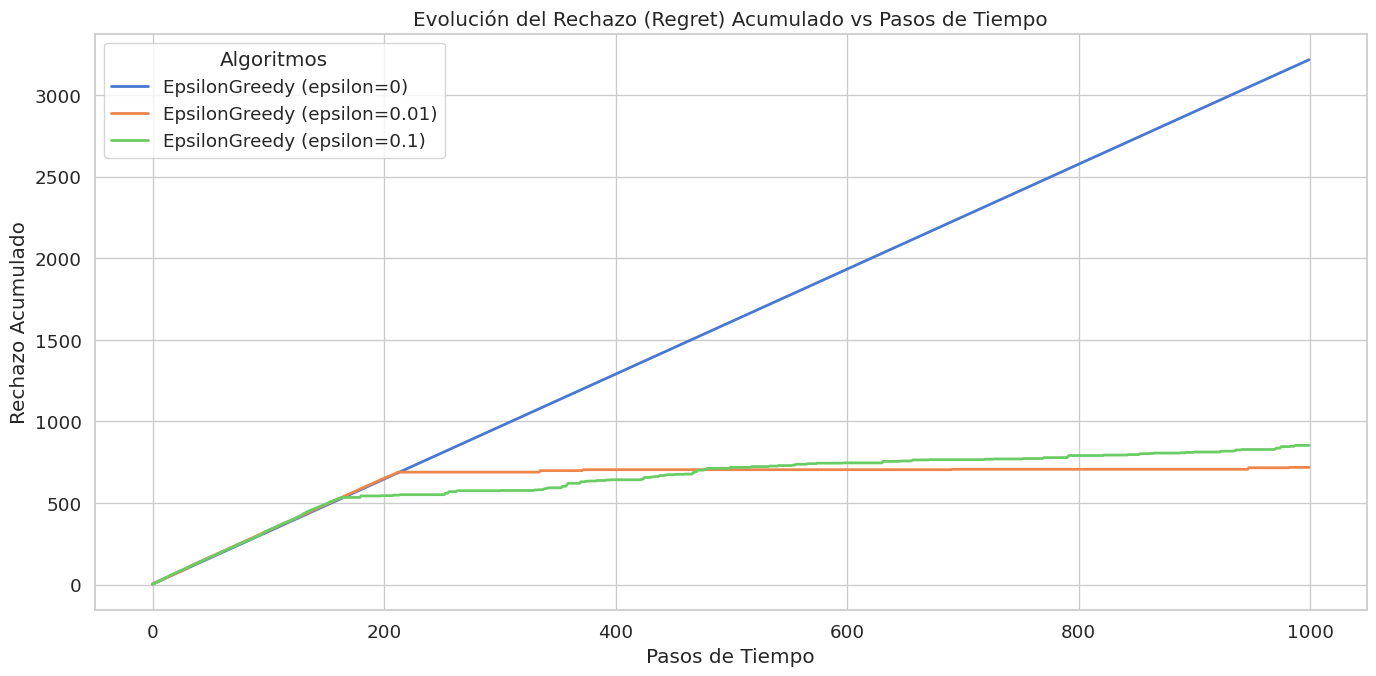

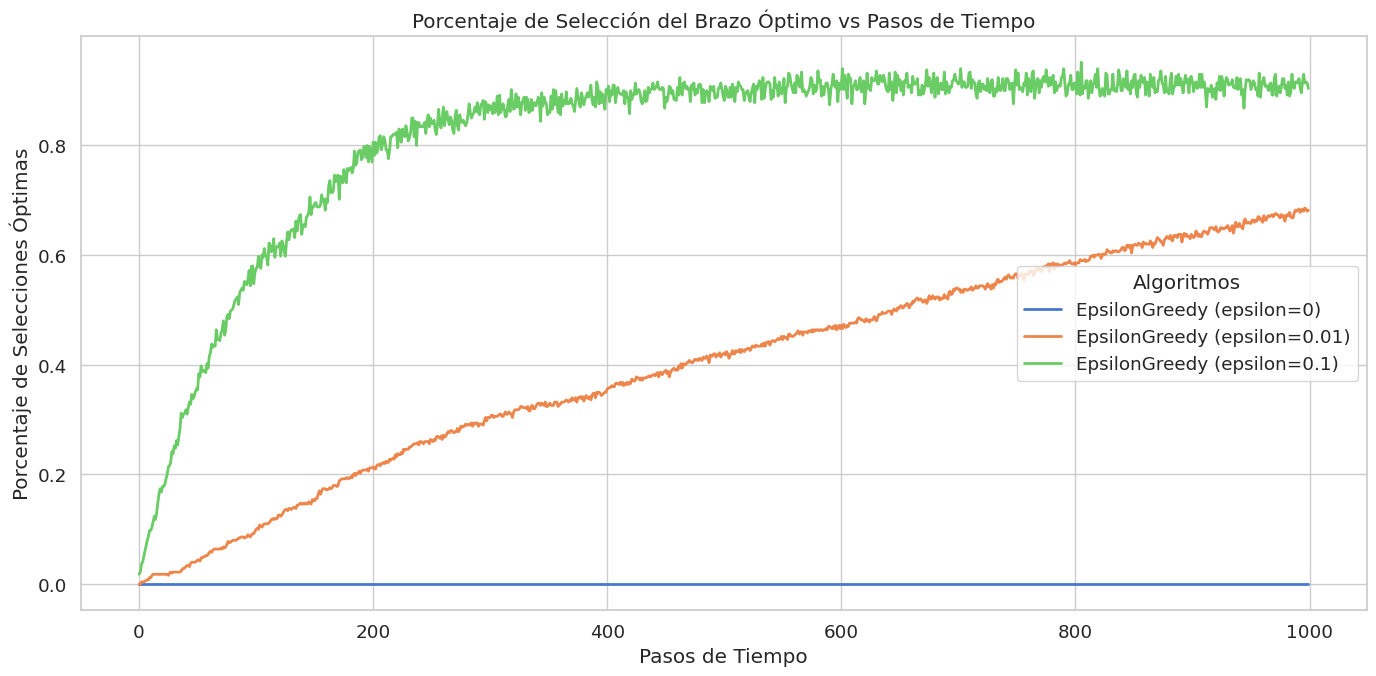

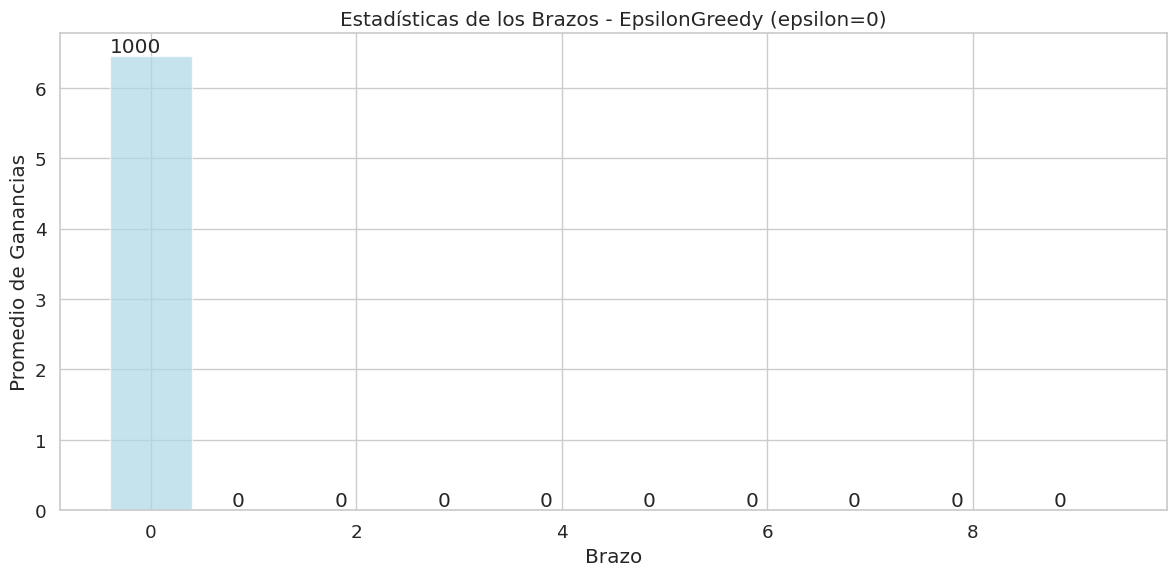

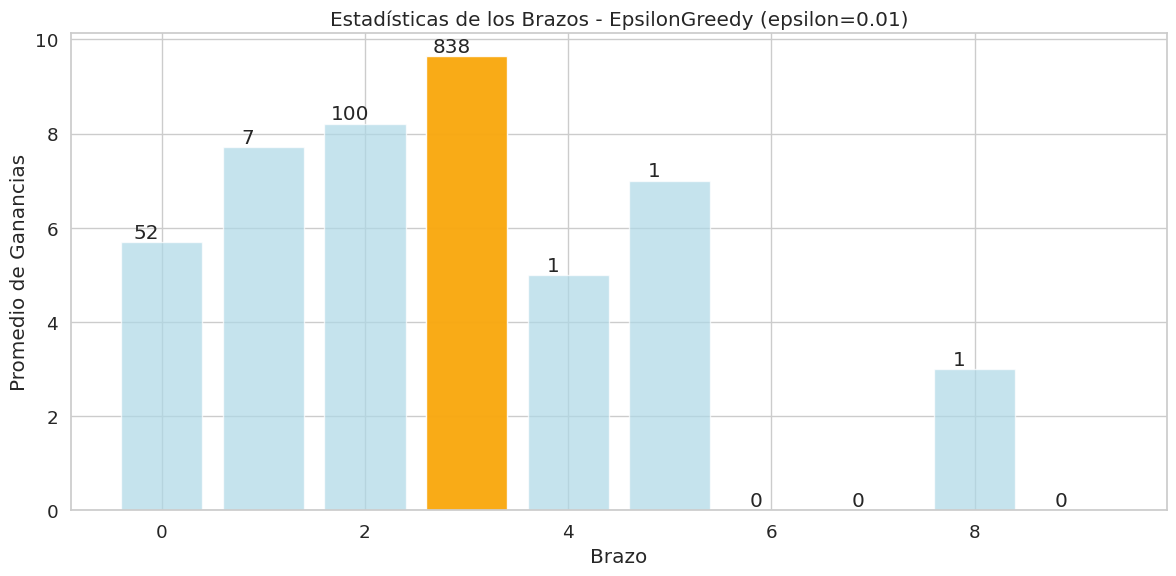

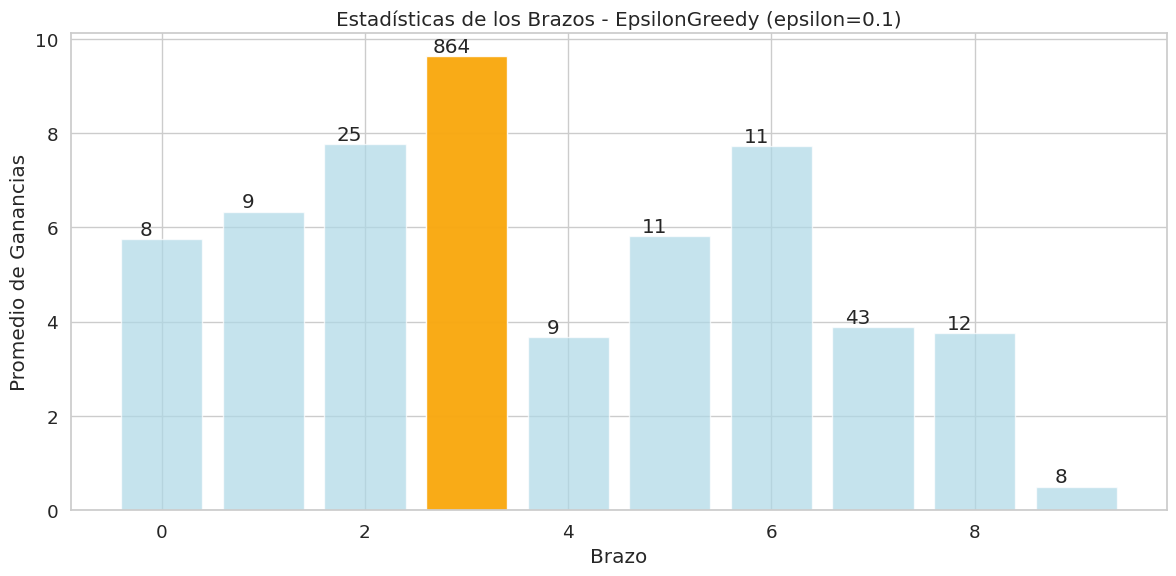

In [6]:
# Parámetros del experimento
seed = 20
np.random.seed(seed)  # Fijar la semilla para reproducibilidad

k = 10  # Número de brazos
steps = 1000  # Número de pasos que se ejecutarán cada algoritmo
runs = 500  # Número de ejecuciones

# Tipos de brazos que se van a utilizar en el experimento
arm_types = {
    'Bernoulli': ArmBernoulli,
    'Binomial': ArmBinomial
}

# Definir los hiperparámetros a comparar para cada algoritmo epsilon_greedy
epsilon_greedy_configs = [0, 0.01, 0.1]  # Valores del parámetro 'epsilon' en epsilon-greedy

# Definir los algoritmos a comparar en la familia epsilon_greedy con diferentes configuraciones
algorithms = []

# Añadir epsilon_greedy con diferentes valores de 'epsilon'
for c in epsilon_greedy_configs:
    algorithms.append(EpsilonGreedy(k=k, epsilon=c))

# Bucle para evaluar cada tipo de brazo con los algoritmos definidos
for arm_name, ArmClass in arm_types.items():
    print(f"\nEvaluando epsilon_greedy con brazos {arm_name}...")

    # Creación del bandit con el tipo de brazo correspondiente
    bandit = Bandit(arms=ArmClass.generate_arms(k))  # Generar un bandido con k brazos según la distribución del tipo de brazo actual
    print(bandit)

    # Obtener el brazo óptimo y su recompensa esperada
    optimal_arm = bandit.optimal_arm
    print(f"Optimal arm: {optimal_arm + 1} with expected reward={bandit.get_expected_value(optimal_arm)}")

    # Ejecutar el experimento y obtener las recompensas promedio, selecciones óptimas, regret acumulado y estadísticas de brazos
    rewards, optimal_selections, regret_accumulated, arm_stats = run_experiment(bandit, algorithms, steps, runs)

    # Graficar los resultados específicos para este tipo de brazo
    print(f"\nResultados para {arm_name}:")
    plot_average_rewards(steps, rewards, algorithms)
    plot_regret(steps, regret_accumulated, algorithms)
    plot_optimal_selections(steps, optimal_selections, algorithms)
    plot_arm_statistics(arm_stats, algorithms)

## Extensión del análisis: Comparativa entre distribuciones Normal, Bernoulli y Binomial

#### **1. Contexto y objetivos**
Tras evaluar el comportamiento de **ε-Greedy** con **recompensas normalmente distribuidas**, ampliamos el estudio a dos tipos de distribución adicionales:

- **Bernoulli:** Salidas binarias (0 o 1).  
- **Binomial:** Variante de Bernoulli aplicable a múltiples ensayos por brazo.

El propósito es analizar cómo la **naturaleza de la recompensa** influye en el desempeño de **ε-Greedy** en términos de:
- **Recompensa media**  
- **Regret acumulado**  
- **Frecuencia de selección del brazo óptimo**

---

#### **2. Recompensa media según la distribución**

- **Normal:**  
  - **ε=0.1** logra la recompensa media más elevada y estable.  
  - **ε=0.01** mejora de forma continua, pero a ritmo más pausado.  
  - **ε=0** muestra un rendimiento pobre al atascarse en un brazo subóptimo.

- **Bernoulli:**  
  - **ε=0.1** sigue obteniendo la mejor media.  
  - Mayor volatilidad en la curva, aunque el algoritmo se ajusta con el tiempo.  
  - **ε=0.01** tarda más en converger que en el caso normal.

- **Binomial:**  
  - Peor recompensa media global.  
  - Convergencia más lenta que en Normal y Bernoulli.  
  - Las diferencias de valor entre brazos se exageran, pero sin tanta consistencia.

**Síntesis:**  
- La distribución **Normal** ofrece el mayor rendimiento y estabilidad.  
- **Bernoulli** introduce mayor variabilidad, pero el patrón de mejora es claro.  
- **Binomial** es la menos eficaz, con menor recompensa media y convergencia más lenta.

---

#### **3. Regret acumulado**

- **Normal (ε=0.1):** Regret mínimo, evidencia un aprendizaje rápido.  
- **Bernoulli:** Regret inicial más elevado, con descenso progresivo.  
- **Binomial:** Regret mayor y persistente, confirmando su menor eficiencia.

**Interpretación:**  
La metodología ε-Greedy funciona mejor con recompensas normales; en Bernoulli el aprendizaje es más ruidoso y en Binomial la adaptación es más lenta.

---

#### **4. Selección del brazo óptimo**

- **Normal:** Con **ε=0.1**, alcanza el porcentaje más alto de elecciones correctas rápidamente.  
- **Bernoulli:** Más dispersión al principio, pero estabiliza la selección del mejor brazo.  
- **Binomial:** Tarda más en converger y presenta menor consistencia.  
- **ε=0:** Cero selecciones del brazo óptimo en todas las distribuciones.

**Conclusión:**  
El algoritmo identifica el brazo óptimo con mayor rapidez en entornos normales; en Bernoulli aparece variabilidad y en Binomial el proceso es más lento.

---

#### **5. Resumen comparativo**

| Métrica                         | Normal                        | Bernoulli                     | Binomial                      |
|---------------------------------|-------------------------------|-------------------------------|-------------------------------|
| **Recompensa media**            | Máxima con ε=0.1              | Variabilidad moderada         | Más baja y lenta              |
| **Regret acumulado**            | Mínimo con ε=0.1              | Alto inicialmente, disminuye  | Más alto y duradero           |
| **Selección del brazo óptimo**  | Rápida y estable              | Ruidosa al inicio, converge   | Lenta y menos fiable          |
| **Influencia de la exploración**| Equilibrada y efectiva        | Requiere más exploración      | Necesita exploraciones prolongadas |

---

#### **6. Conclusiones finales**
1. **Distribución Normal:** Óptima para ε-Greedy—aprendizaje ágil y consistente.  
2. **Distribución Bernoulli:** Introduce ruido inicial, pero con exploración suficiente puede rendir bien.  
3. **Distribución Binomial:** Convergencia tardía y mayor regret; plantear métodos alternativos.  
4. **ε = 0:** Ineficaz en cualquier escenario, al no explorar.

> **Recomendación práctica:**  
> - Si las recompensas siguen una **Normal**, ε-Greedy funciona de manera rápida y estable.  
> - En casos **binarios**, conviene aumentar ε para mitigar la variabilidad.  
> - Si los resultados son **binomiales**, valorar estrategias diferentes o combinaciones adaptativas de ε.  
